In [137]:
import pandas as pd

train_data_with_cone = pd.read_parquet('../ml/processed_events_50k/raw_cone_data.parquet')

In [138]:
import sys
sys.path.insert(0, "../")
from ml.generate_cone_data import normalize_cone_features

In [139]:
train_data_with_cone = train_data_with_cone.astype('float32')
train_data_with_cone = train_data_with_cone.dropna()

In [140]:
train_data_with_cone

,event_id,primary_kinetic_energy,min_plane,max_plane,X_mean_min,Y_mean_min,Z_mean_min,X_mean_max,Y_mean_max,Z_mean_max,radius,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith
0,4.489313e+09,5.640506e+06,4.0,0.0,36.378830,-0.305622,6376999.5,214.353073,-2.448661,6386998.0,612.912354,0.000949,1.000000,0.018375,0.999831
1,4.489320e+10,4.762262e+06,1.0,0.0,12.193157,-0.770679,6375500.0,267.529999,2.727913,6386997.0,490.121582,0.004434,0.999990,0.022497,0.999747
2,4.489328e+10,1.297907e+07,2.0,0.0,32.515026,3.005188,6375999.5,403.547974,24.647030,6386993.0,343.945862,0.065306,0.997865,0.033058,0.999453
3,4.489324e+09,3.933470e+06,3.0,0.0,13.810337,1.835706,6376500.0,101.324654,7.838173,6386999.5,524.609558,0.109408,0.993997,0.009567,0.999954
4,4.489327e+09,8.732883e+05,2.0,0.0,14.222742,-0.419800,6376000.0,160.586533,5.579242,6386999.0,858.970154,0.099865,0.995001,0.013858,0.999904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46927,4.489327e+10,1.521272e+07,2.0,0.0,31.561373,2.878999,6375999.5,395.348846,39.391151,6386993.5,764.011169,0.105722,0.994396,0.033599,0.999435
46928,4.489311e+10,1.120772e+07,1.0,0.0,13.602057,0.480155,6375500.0,326.815430,5.200869,6386995.5,322.817139,0.036242,0.999343,0.027215,0.999630
46929,4.489322e+10,8.348586e+06,8.0,0.0,43.470726,1.351575,6379000.0,125.560623,5.583314,6386999.5,370.954132,0.033368,0.999443,0.010863,0.999941
46930,4.489325e+10,2.383711e+06,1.0,0.0,5.693599,-0.551353,6375500.0,98.230904,-1.161005,6386999.5,356.264740,0.028359,0.999598,0.008054,0.999968


In [141]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(train_data_with_cone.drop(columns=['min_plane', 'max_plane'])))
# remove data beyond 2 standard deviations
train_data_with_cone = train_data_with_cone[(z_scores < 1).all(axis=1)].reset_index(drop=True)

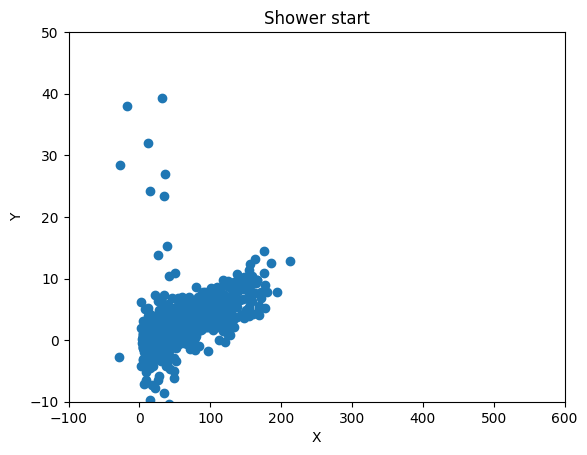

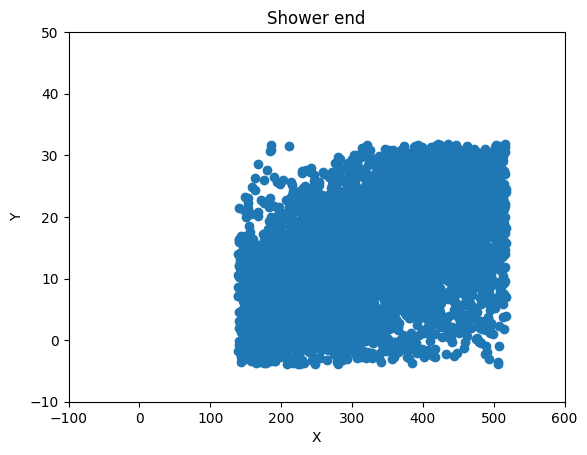

In [145]:
import matplotlib.pyplot as plt
plt.title('Shower start')
plt.scatter(train_data_with_cone['X_mean_min'],train_data_with_cone['Y_mean_min'] )
plt.xlim([-100, 600])
plt.ylim([-10, 50])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.title('Shower end')
plt.scatter(train_data_with_cone['X_mean_max'],train_data_with_cone['Y_mean_max'] )
plt.xlim([-100, 600])
plt.ylim([-10, 50])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [113]:
train_data_with_cone = normalize_cone_features(train_data_with_cone)

In [114]:
# enable autoreloading of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from src.plotting import plot_2d_scatter, plot_histogram, plot_records_per_plane, plot_cone_with_scatter, plot_y_values_per_plane, generate_3d_cone_animation
from src.data_exploration import calculate_max_records_events, select_event_data, print_y_values_per_plane
from src.featurization import calcualte_cone_parameters


# Prepare training data

Select input and output columns

In [116]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
    'X_mean_min', 'Y_mean_min', 'Z_mean_min',
    'X_mean_max', 'Y_mean_max', 'Z_mean_max',
    'radius'
]
batch_identifier = "event_id"

Calculate meand and std of secondary features

In [117]:
print(f"Event stats columns: {train_data_with_cone.columns}")
print(f"Input columns: {input_columns}")
print(f"Output columns: {output_columns}")

Event stats columns: Index(['primary_kinetic_energy', 'X_mean_min', 'Y_mean_min', 'Z_mean_min',
       'X_mean_max', 'Y_mean_max', 'Z_mean_max', 'radius', 'event_id',
       'min_plane', 'max_plane', 'sin_azimuth', 'cos_azimuth', 'sin_zenith',
       'cos_zenith'],
      dtype='object')
Input columns: ['primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith']
Output columns: ['X_mean_min', 'Y_mean_min', 'Z_mean_min', 'X_mean_max', 'Y_mean_max', 'Z_mean_max', 'radius']


# Define NN using PINA

Test train split

In [118]:
from sklearn.preprocessing import StandardScaler

# split inputs and outputs 
X = train_data_with_cone[input_columns]
y = train_data_with_cone[output_columns]


# y_normalized = y - y.mean()
# y_max = y_normalized.max().max()
# y_normalized = y_normalized / y_max

# create scaler for each output column
y_scaler = StandardScaler()

# fit and transform each column separately
y_normalized = y_scaler.fit_transform(y)

PINA

In [119]:
from pina import Trainer, Condition, LabelTensor
from pina.problem import AbstractProblem
from src.nn import Model
from pina.optim import TorchOptimizer, TorchScheduler
from pina.solver import DeepEnsembleSupervisedSolver
from pina.callback import MetricTracker
import torch



In [120]:
x_pina = LabelTensor(X.to_numpy(dtype=np.float64), input_columns)
y_pina = LabelTensor(y_normalized, output_columns)

In [121]:
class BayesianProblem(AbstractProblem):

    output_variables = output_columns
    input_variables = input_columns
    conditions = {"data": Condition(input=x_pina, target=y_pina)}


problem = BayesianProblem()

In [122]:
n_models = 2

# define problem & data (step 1)


models = [
  Model(
      input_dimensions=len(problem.input_variables),
      output_dimensions=len(problem.output_variables),
      layers=[100, 100, 100],
      func=torch.nn.Tanh
  )
  for _ in range(n_models)
]

optimizers = [
     TorchOptimizer(torch.optim.RAdam, lr=0.005)
     for _ in range(n_models)
]

schedulers = [
    TorchScheduler(torch.optim.lr_scheduler.MultiStepLR, milestones=[50, 100, 300, 500, 800], gamma=0.5)
    for _ in range(n_models)
]

In [123]:
solver = DeepEnsembleSupervisedSolver(
    problem,
    models,
    optimizers=optimizers,
    schedulers=schedulers
    )

In [124]:
# create the trainer
trainer = Trainer(
    solver=solver,  # The ensemble solver
    max_epochs=1500,  # Maximum number of training epochs
    logger=True,  # Enables logging (default logger is CSVLogger)
    callbacks=[MetricTracker()],  # Tracks training metrics using MetricTracker
    accelerator="cpu",  # Use CPU for training, alternative is "gpu" for GPU training
    train_size=0.7,  # Fraction of the dataset used for training (70%)
    test_size=0.2,  # Fraction of the dataset used for testing (20%)
    val_size=0.1,  # Fraction of the dataset used for validation (10%)
)

import time

start = time.time()
# train
trainer.train()
end = time.time()
print(f"Training time: {end - start} seconds")

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\zdimi\AppData\Local\Python\pythoncore-3.14-64\Lib\logging\__init__.py", line 1154, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zdimi\AppData\Local\Python\pythoncore-3.14-64\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4a1' in position 47: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\zdimi\AppData\Roaming\Python\Python314\site-pac

Epoch 1499: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s, v_num=2, val_loss=0.607, data_loss=0.597, train_loss=0.597]

INFO: `Trainer.fit` stopped: `max_epochs=1500` reached.
2025-12-03 11:08:29,358 - INFO - MainProcess - `Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s, v_num=2, val_loss=0.607, data_loss=0.597, train_loss=0.597]
Training time: 542.6244115829468 seconds


Plot loss

In [130]:
# inspecting final loss
trainer.logged_metrics

{'val_loss': tensor(0.6074),
 'data_loss': tensor(0.5966),
 'train_loss': tensor(0.5966)}

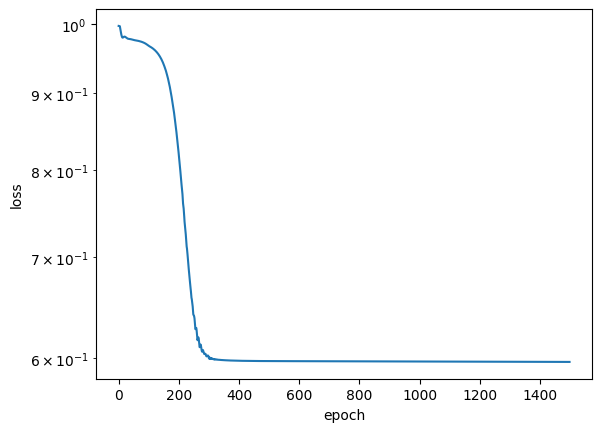

In [131]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
loss = trainer_metrics["train_loss"]
epochs = range(len(loss))
plt.plot(epochs, loss.cpu())
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

# Test NN: Plot errors in output/target features

In [132]:
all_outputs = None
all_targets = None

trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
    # for data in trainer.data_module.train_dataloader():
        inputs, target = data[0][1]["input"], data[0][1]["target"]
        outputs = solver(inputs)
        
        if all_outputs is None:
            all_outputs = LabelTensor(outputs, labels=output_columns)
            all_targets = target
        else:
            all_outputs.append(LabelTensor(outputs, labels=output_columns))
            all_targets.append(target)
        break

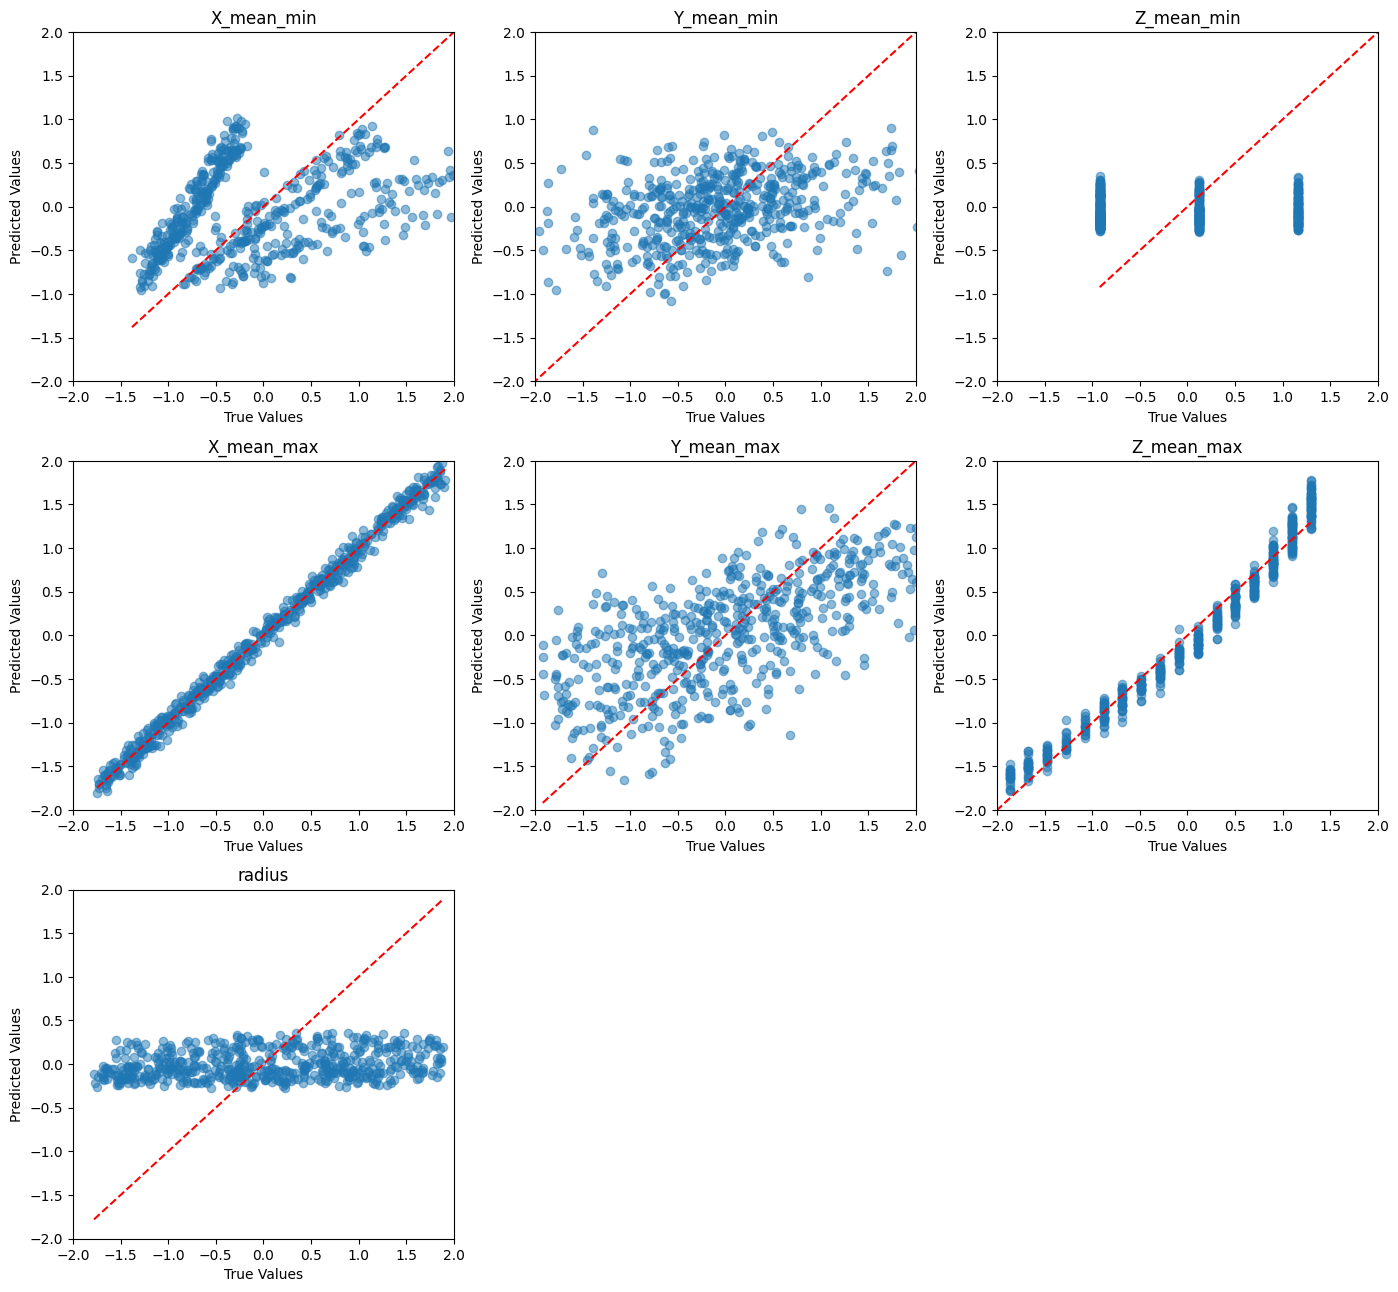

In [134]:
# plot targets vs predictions for validation set
y_mean, y_std = all_outputs.mean(0).detach(), all_outputs.std(0).detach()
true_output = all_targets.detach()

plt.figure(figsize=(14, 13))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//3+1, 3, i+1)
    plt.scatter(true_output[:, i], y_mean[:, i], alpha=0.5)#, s=20*y_std[:, i]/y_std.max())
    plt.plot([true_output[:, i].min(), true_output[:, i].max()],
             [true_output[:, i].min(), true_output[:, i].max()], 'r--')
    
    # plt.xlim([true_output[:, i].min(), true_output[:, i].max()])
    # plt.ylim([true_output[:, i].min(), true_output[:, i].max()])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(col)
plt.tight_layout(pad=1.0)
